# Exercise 1
Linear models are an important class in data analysis problems. Your aim for this exercise is using such an approach modeling of !Kung people heights (applying Stan).

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults for now
d.sort_values(by=['weight'],inplace=True)
d.head()

,height,weight,age,male
210,143.510,31.071052,18.0,0
184,141.605,31.524644,19.0,1
373,142.240,31.666391,36.0,0
2,136.525,31.864838,65.0,0
244,146.050,31.864838,44.0,0


Using Stan create the linear model for presented data and interpret the results.

To create model for !Kung people's heights we need to get some information about how does heigh distribution tends to look like. From information avaliable online we can learn that distribution of heights like many other variables found in nature tends to be normaly distributed. So we can assume:
$$height \sim\mathrm Normal(\mu,\sigma)$$
Using linear model approach we have to link mean of normal distribution seen above to some predictor variable as a linear function of this variable. 
$$ \mu = \alpha + \beta P_v, $$ where $P_v$ is our choosen predictor variable. We'll plot our data against eatch otcher to better understand whitch predictor we should use. 

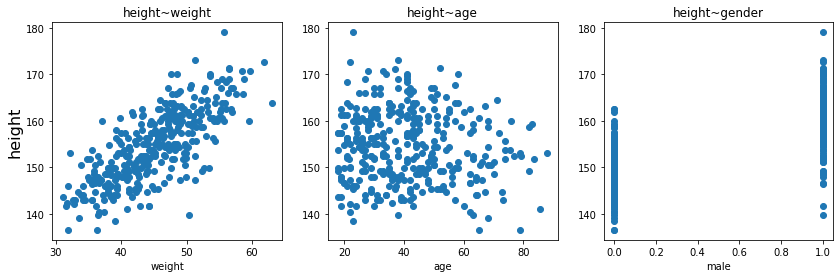

In [3]:
#Plotting heigh against other possible predictors in our data
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].scatter(d["weight"], d["height"]);
axes[0].set_ylabel("height", fontsize=16);
axes[0].set_title("height~weight")
axes[0].set_xlabel("weight");
axes[1].scatter(d["age"], d["height"]);
axes[1].set_title("height~age")
axes[1].set_xlabel("age");
axes[2].scatter(d["male"], d["height"]);
axes[2].set_xlabel("male");
axes[2].set_title("height~gender");

From all the possible predictors in our data, weight looks like the best option. So asserting $P_v$ as weight our model looks like: 
$$height \sim\mathrm Normal(\mu,\sigma),$$
$$ \mu = \alpha + \beta(w-\bar{w}), $$
Now we have to assert proper priors for $\alpha$ and $\beta$. For estimating $\alpha$ priors we can start by getting histogram of height data. Assuming predictor value has no impact ($\beta = 0$):

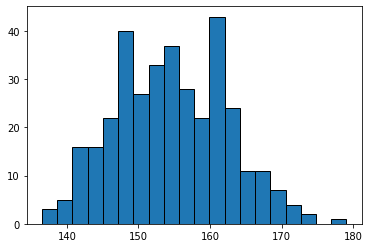

In [4]:
fig, axes = plt.subplots()
axes.hist(d["height"], bins=20, edgecolor='black')
plt.show()

We can notice that it does look Gaussian in shape. Because we can't get any informatior to create informative priori on alpha like what heigh is favoured by natural selection in their environmet we have to use weakly informative priori. Let's use data from Botswana with lies near the teritories !Kung Sao people occupy. 
Mean heigh of women in Botswana is 160.9 cm while males is 170.9 cm. Botswana male to female ratio is around 94 males for 100 females so we can assume mean height is 166 cm. Setting variance as 20 seems reasonable. So that gives us model: 
$$height \sim\mathrm Normal(\mu,\sigma),$$
$$ \mu = \alpha + \beta (w-\bar{w}), $$
$$ \alpha \sim\mathrm Normal(166,20) $$
$$ \sigma \sim\mathrm Uniform(0,20) $$
Now we have to estimate prior for $\beta$. Let's start by assuming $\beta \sim\mathrm Normal(0,2)$.

In [5]:
with open('prio1.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real W[N];
}

generated quantities {
  real alpha = normal_rng(166,20);
  real beta = normal_rng(0,5);
  real<lower = 0> sigma = uniform_rng(0,20);
  real y_sim[N];
  for (k in 1:N) {
    y_sim[k] = normal_rng(beta*W[N]+alpha,sigma);
  }
}



In [6]:
weight = (d["weight"]-np.mean(d["weight"]))
model_prior_uni=CmdStanModel(stan_file='prio1.stan')
Wn=np.arange(d["weight"].min(), d["weight"].max(), 0.2).tolist()
W = Wn - np.mean(Wn)
data=dict(N=len(W),W=W)
sim=model_prior_uni.sample(data=data,
                     fixed_param=True, 
                     iter_warmup=0, 
                     chains=1)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /mnt/c/ola/DataAnalytics/lab05/prio1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


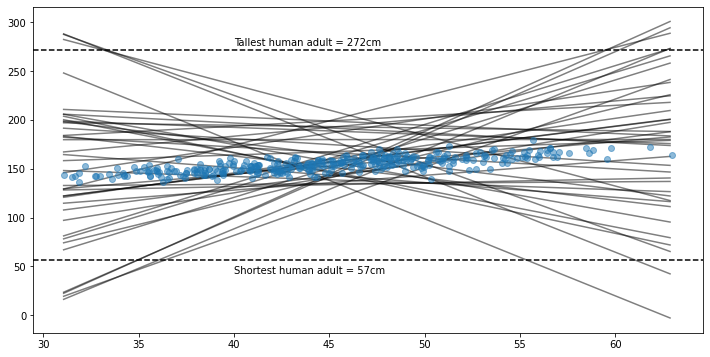

In [7]:
alpha_sim=sim.stan_variable('alpha')
beta_sim=sim.stan_variable('beta')
y_sim=sim.stan_variable('y_sim')

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(40):
    ax.plot(Wn,alpha_sim[i]+beta_sim[i]*W, alpha=0.5,zorder=0, color='black')
ax.scatter(d.weight,d.height,alpha=0.5)
ax.axhline(272, color = 'black', linestyle='--')
ax.text(40,276,'Tallest human adult = 272cm')

ax.axhline(57, color = 'black', linestyle='--')
ax.text(40,43,'Shortest human adult = 57cm')

plt.show()

As we can see on plot above priors we've choosen poorly align with our knowledge about height-weight correlation. Seeing that it's impossible for people to get lighter as their height increase we can assume that it has to be > 0. To make it so we'll define beta as Log-Normal distribution. So our model looks like:
$$height \sim\mathrm Normal(\mu,\sigma),$$
$$ \mu = \alpha + \beta (w-\bar{w}), $$
$$ \alpha \sim\mathrm Normal(166,20) $$
<center> $\beta \sim\mathrm Log$-$Normal(0,1)$ </center>
$$ \sigma \sim\mathrm Uniform(0,20) $$

In [8]:
model_prior_uni=CmdStanModel(stan_file='prio2.stan')
Wn = np.arange(d["weight"].min(), d["weight"].max(), 0.2).tolist()
W = Wn - np.mean(Wn)
data=dict(N=len(W),W=W)
sim=model_prior_uni.sample(data=data,
                     fixed_param=True, 
                     iter_warmup=0, 
                     chains=1)
alpha_sim=sim.stan_variable('alpha')
beta_sim=sim.stan_variable('beta')
y_sim=sim.stan_variable('y_sim')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /mnt/c/ola/DataAnalytics/lab05/prio2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


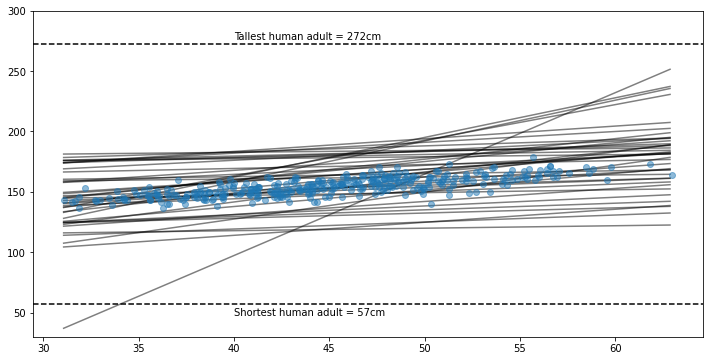

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(40):
    ax.plot(Wn,alpha_sim[i]+beta_sim[i]*W, alpha=0.5,zorder=0,color = 'black')
ax.scatter(d.weight,d.height,alpha = 0.5)
ax.axhline(272, color = 'black', linestyle='--')
ax.text(40,276,'Tallest human adult = 272cm')

ax.axhline(57, color = 'black', linestyle='--')
ax.text(40,48,'Shortest human adult = 57cm')
ax.set_ylim([30 ,300])
plt.show()

We can observe that our priors look more sensible then before. Now using this priors we'll create model of height data. Our model: 
$$height \sim\mathrm Normal(\mu,\sigma),$$
$$ \mu = \alpha + \beta (w-\bar{w}), $$
$$ \alpha \sim\mathrm Normal(166,20) $$
<center> $\beta \sim\mathrm Log$-$Normal(0,1)$ </center>
$$ \sigma \sim\mathrm Uniform(0,20) $$
written using stan code looks like: 

In [10]:
with open('model1.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] W;
  real h[N];
  int GL;
  vector[GL] gen;
}

parameters {
  real alpha;
  real beta;
  real<lower=0, upper=20> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = alpha + beta * (W[i]);
  }
}

model {
  alpha ~ normal(166,20);
  beta ~ lognormal(0,1);
  sigma ~ uniform(0,20);
  h ~ normal(mu, sigma);
}

generated quantities {
  real h_sim[GL];
  for (i in 1:GL) {
    h_sim[i] = normal_rng(alpha + beta*(gen[i]), sigma);
  }
}



In [11]:
model_post1=CmdStanModel(stan_file='model1.stan')
weight = (d["weight"]-np.mean(d["weight"]))
w_sq=np.arange(d["weight"].min(), d["weight"].max(), 0.2)
to_get=(w_sq-np.mean(w_sq))
data=dict(N=len(weight), W=weight.tolist(), h=d.height.values, GL=len(to_get), gen=to_get.tolist())
fit=model_post1.sample(data=data)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /mnt/c/ola/DataAnalytics/lab05/model1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [12]:
az.summary(fit,var_names=['alpha','beta','sigma'],kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,154.596,0.272,154.110,155.134
beta,0.902,0.043,0.821,0.980
sigma,5.106,0.198,4.744,5.475


/mnt/c/Users/jkurek1/Desktop/DataAnalytics/venv/lib/python3.6/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


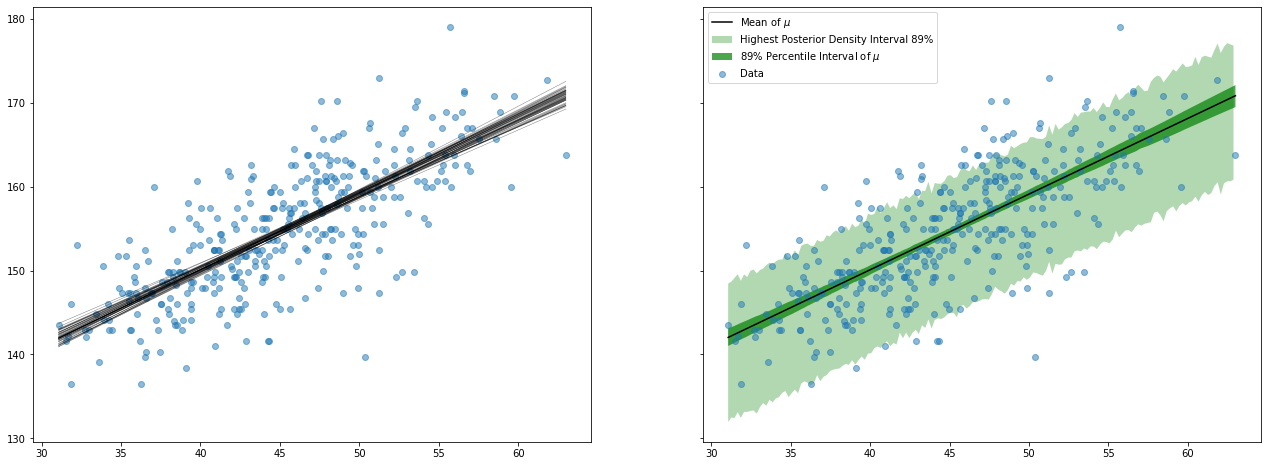

In [13]:
alpha_fit=fit.stan_variable('alpha')
beta_fit=fit.stan_variable('beta')
mu_fit=fit.stan_variable('mu')
h_sim=fit.stan_variable('h_sim')
hdi_height = az.hdi(h_sim, 0.89)
hdi_mu = az.hdi(mu_fit, 0.89)

fig, axes = plt.subplots(1,2, figsize=(22, 8),sharey=True,sharex=True)
axes[0].scatter(d.weight,d.height,alpha=0.5)
for i in range(50):
    axes[0].plot(d.weight, alpha_fit[i]+beta_fit[i]*weight, color = 'black', alpha=0.5,linewidth=0.5)

axes[1].fill_between(w_sq, hdi_height[:,0], hdi_height[:,1], facecolor='green', alpha=0.3);
axes[1].fill_between(d.weight.values, hdi_mu[:,0], hdi_mu[:,1], facecolor='green', alpha=0.7);
axes[1].scatter(d.weight,d.height,alpha=0.5)
axes[1].plot(d.weight.values, np.mean(mu_fit,0), color='black')
axes[1].legend(['Mean of $\mu$', 'Highest Posterior Density Interval 89%', '89% Percentile Interval of $\mu$', 'Data'])
plt.show()

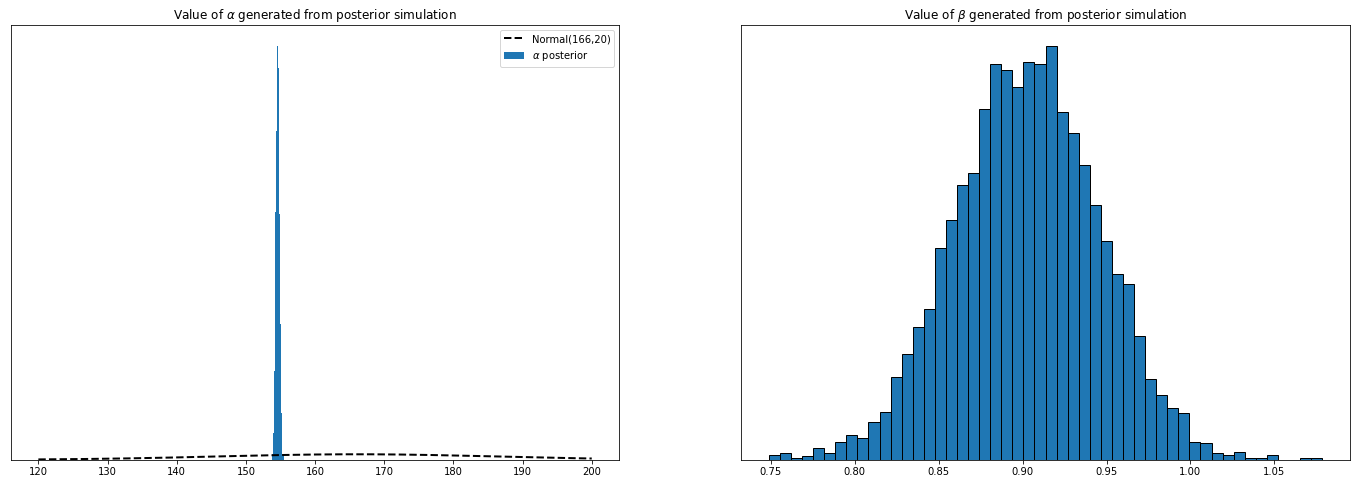

In [14]:
fig, ax = plt.subplots(1,2, figsize=(24, 8))
ax[0].hist(alpha_fit, bins=50, density=True)
x=np.linspace(120,200,1000)
ax[0].set_title(r'Value of $\alpha$ generated from posterior simulation')
ax[0].plot(x, stats.norm.pdf(x, 166, 20), color='black', linestyle='dashed', linewidth=2)
ax[0].legend(['Normal(166,20)',r'$\alpha$ posterior'])
ax[0].set_yticks([])

ax[1].hist(beta_fit, bins=50, density=True,edgecolor='black')
ax[1].set_title(r'Value of $\beta$ generated from posterior simulation')
ax[1].set_yticks([])
plt.show()

# Exercise 2
Extend model of !Kung people height for the full dataset (including children) and discuss the results.

In [15]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d.sort_values(by=['weight'],inplace=True)
d.head()

,height,weight,age,male
517,53.9750,4.252425,0.0,0
466,55.8800,4.847764,0.0,0
519,56.5150,5.159609,0.0,0
354,60.4520,5.669900,1.0,1
325,59.6138,5.896696,1.0,0


Let's plot data for all of !Kung Sao people, including children. Just like in previous example we'll be using weight as a predictor variable. 

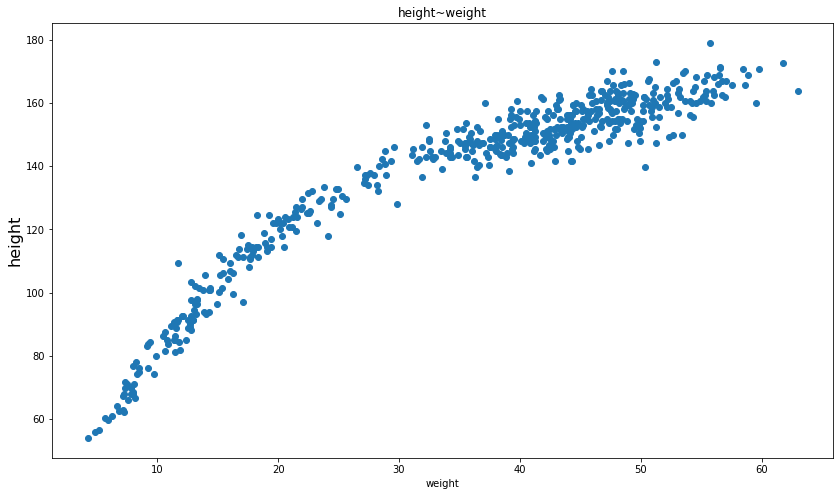

In [16]:
#Plotting heigh against other possible predictors in our data
fig, axes = plt.subplots(figsize=(14, 8))
axes.scatter(d["weight"], d["height"]);
axes.set_ylabel("height", fontsize=16);
axes.set_title("height~weight")
axes.set_xlabel("weight");

From the plot above we can tell that linear regression is not going to be enought, we'll have to use polynomial regression to build better curve association. Still we can use our model created for linear regression to see how it's gonna behave for full data set. 

In [17]:
weight = (d["weight"]-np.mean(d["weight"]))
w_sq=np.arange(d["weight"].min(), d["weight"].max(), 0.2)
to_get=(w_sq-np.mean(w_sq))
data=dict(N=len(weight), W=weight.tolist(), h=d.height.values, GL=len(to_get), gen=to_get.tolist())
fit=model_post1.sample(data=data)
az.summary(fit,var_names=['alpha','beta','sigma'],kind='stats')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


,mean,sd,hdi_3%,hdi_97%
alpha,138.281,0.408,137.518,139.022
beta,1.764,0.028,1.712,1.817
sigma,9.383,0.289,8.860,9.947


/mnt/c/Users/jkurek1/Desktop/DataAnalytics/venv/lib/python3.6/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


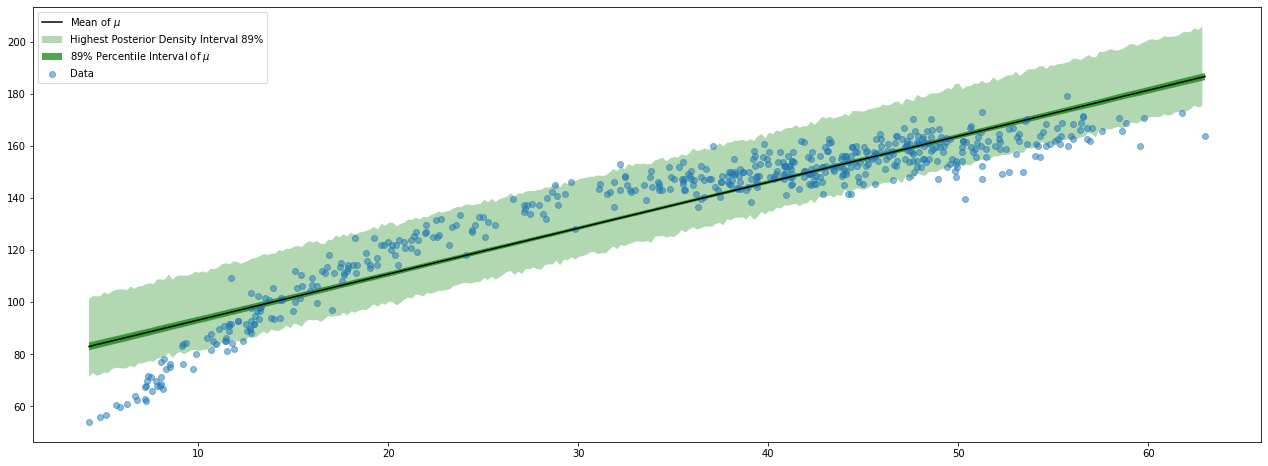

In [18]:
alpha_fit=fit.stan_variable('alpha')
beta_fit=fit.stan_variable('beta')
mu_fit=fit.stan_variable('mu')
h_sim=fit.stan_variable('h_sim')
hdi_height = az.hdi(h_sim, 0.89)
hdi_mu = az.hdi(mu_fit, 0.89)

fig, axes = plt.subplots(figsize=(22, 8))

axes.fill_between(w_sq, hdi_height[:,0], hdi_height[:,1], facecolor='green', alpha=0.3);
axes.fill_between(d.weight.values, hdi_mu[:,0], hdi_mu[:,1], facecolor='green', alpha=0.7);
axes.scatter(d.weight,d.height,alpha=0.5)
axes.plot(d.weight.values, np.mean(mu_fit,0), color='black')
axes.legend(['Mean of $\mu$', 'Highest Posterior Density Interval 89%', '89% Percentile Interval of $\mu$', 'Data'])
plt.show()

To create better fit for our data we'll have to use Polynomial regression. To create polynomial regression we'll have to add powers of our predictor variable into model. First we'll try creating second order regression for our fit. We can describe our model as: 
$$height \sim\mathrm Normal(\mu,\sigma),$$
$$ \mu = \alpha + \beta_1 (w-\bar{w}) + \beta_2 (w-\bar{w})^2, $$
$$ \alpha \sim\mathrm Normal(166,20) $$
<center> $\beta_1 \sim\mathrm Log$-$Normal(0,1)$ </center>
$$\beta_2 \sim\mathrm Normal(-0.5,0.2)$$
$$ \sigma \sim\mathrm Uniform(0,20) $$

In [19]:
with open('prio3.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real W[N];
}

generated quantities {
  real alpha = normal_rng(166,20);
  real beta1 = lognormal_rng(0,1);
  real beta2 = normal_rng(-0.5,0.2);
  real sigma = uniform_rng(0,10);

  real y_sim[N];
  for (k in 1:N) {
    y_sim[k] = normal_rng(beta2 * W[N]^2 + beta1*W[N]+alpha,sigma);
  }
}



In [20]:
model_prior_quad=CmdStanModel(stan_file='prio3.stan')
Wn = np.arange(d["weight"].min(), d["weight"].max(), 0.2).tolist()
W = Wn - np.mean(Wn)
data=dict(N=len(W),W=W)
sim=model_prior_quad.sample(data=data,
                     fixed_param=True, 
                     iter_warmup=0, 
                     chains=1)
alpha_sim=sim.stan_variable('alpha')
beta1_sim=sim.stan_variable('beta1')
beta2_sim=sim.stan_variable('beta2')
y_sim=sim.stan_variable('y_sim')

INFO:cmdstanpy:compiling stan program, exe file: /mnt/c/ola/DataAnalytics/lab05/prio3
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /mnt/c/ola/DataAnalytics/lab05/prio3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


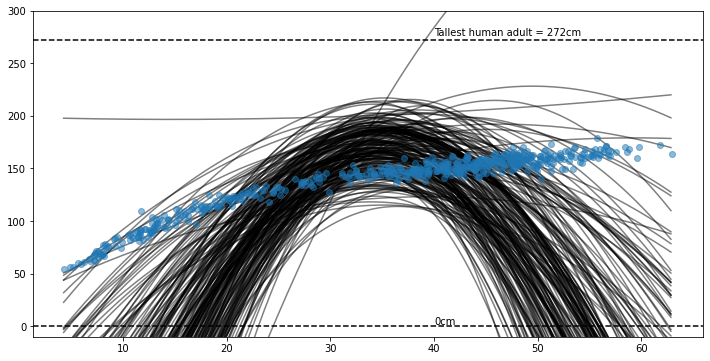

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(200):
    tepp = alpha_sim[i]+beta1_sim[i]*W + beta2_sim[i]*(W**2)
    ax.plot(Wn,tepp, alpha=0.5,zorder=0,color = 'black')
    
ax.scatter(d.weight,d.height,alpha = 0.5)
ax.axhline(272, color = 'black', linestyle='--')
ax.text(40,276,'Tallest human adult = 272cm')

ax.axhline(0, color = 'black', linestyle='--')
ax.text(40,2,'0cm')
ax.set_ylim([-10 ,300])
plt.show()

In [22]:
with open('post_quad.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] W;
  vector[N] W2;
  real h[N];
  int GL;
  vector[GL] gen;
  vector[GL] gen2;
}

parameters {
  real alpha;
  real beta1;
  real beta2;
  real<lower=0, upper=20> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = alpha + beta1 * (W[i]) + beta2 * (W2[i]);
  }
}

model {
  alpha ~ normal(166,20);
  beta1 ~ lognormal(0,1);
  beta2 ~ normal(-0.5,0.2);
  sigma ~ uniform(0,20);
  h ~ normal(mu, sigma);
}

generated quantities {
  real h_sim[GL];
  for (i in 1:GL) {
    h_sim[i] = normal_rng(alpha + beta1*(gen[i]) + beta2*(gen2[i]), sigma);
  }
}



In [23]:
model_quad=CmdStanModel(stan_file='post_quad.stan')

INFO:cmdstanpy:compiling stan program, exe file: /mnt/c/ola/DataAnalytics/lab05/post_quad
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /mnt/c/ola/DataAnalytics/lab05/post_quad


In [24]:
weight = (d["weight"]-np.mean(d["weight"]))
weight2 = weight**2
#w_sq=np.arange(d["weight"].min(), d["weight"].max(), 0.01)
to_get= weight 
to_get2 = to_get**2
data=dict(N=len(weight), W=weight.tolist(), W2=weight2.tolist(), h=d.height.values, GL=len(to_get), gen=to_get.tolist(), gen2=to_get2.tolist())
fit=model_quad.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


In [25]:
az.summary(fit,var_names=['alpha','beta1','beta2','sigma'],kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,146.682,0.376,145.970,147.386
beta1,1.453,0.020,1.415,1.490
beta2,-0.039,0.001,-0.041,-0.036
sigma,5.782,0.175,5.459,6.107


/mnt/c/Users/jkurek1/Desktop/DataAnalytics/venv/lib/python3.6/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


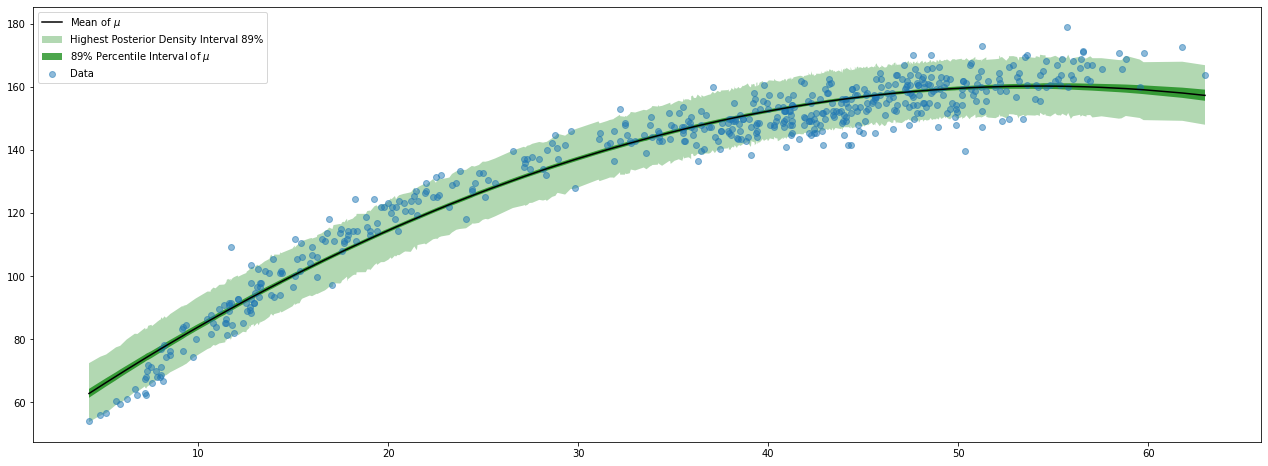

In [26]:
alpha_fit=fit.stan_variable('alpha')
beta1_fit=fit.stan_variable('beta1')
beta2_fit=fit.stan_variable('beta2')
mu_fit=fit.stan_variable('mu')
h_sim=fit.stan_variable('h_sim')
hdi_height = az.hdi(h_sim, 0.89)
hdi_mu = az.hdi(mu_fit, 0.89)

fig, axes = plt.subplots(figsize=(22, 8))

axes.fill_between(d.weight.values, hdi_height[:,0], hdi_height[:,1], facecolor='green', alpha=0.3);
axes.fill_between(d.weight.values, hdi_mu[:,0], hdi_mu[:,1], facecolor='green', alpha=0.7);
axes.scatter(d.weight,d.height,alpha=0.5)
axes.plot(d.weight.values, np.mean(mu_fit,0), color='black')
axes.legend(['Mean of $\mu$', 'Highest Posterior Density Interval 89%', '89% Percentile Interval of $\mu$', 'Data'])
plt.show()

Regression with 3rd order polynomial: 

$$height \sim\mathrm Normal(\mu,\sigma),$$
$$ \mu = \alpha + \beta_1 (w-\bar{w}) + \beta_2 (w-\bar{w})^2 + \beta_3 (w-\bar{w})^3, $$
$$ \alpha \sim\mathrm Normal(166,20)$$
<center> $\beta_1 \sim\mathrm Log$-$Normal(0,1)$ </center>
$$\beta_2 \sim\mathrm Normal(-0.5,0.2)$$
$$\beta_3 \sim\mathrm Normal(0,1)$$
$$ \sigma \sim\mathrm Uniform(0,20) $$

In [27]:
with open('post_3rd.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] W;
  vector[N] W2;
  vector[N] W3;
  real h[N];
  int GL;
  vector[GL] gen;
  vector[GL] gen2;
  vector[GL] gen3;
}

parameters {
  real alpha;
  real beta1;
  real beta2;
  real beta3;
  real<lower=0, upper=20> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = alpha + beta1 * (W[i]) + beta2 * (W2[i]) + beta3 * (W3[i]);
  }
}

model {
  alpha ~ normal(166,20);
  beta1 ~ lognormal(0,1);
  beta2 ~ normal(-0.5,0.2);
  beta3 ~ normal(0,1);
  sigma ~ uniform(0,20);
  h ~ normal(mu, sigma);
}

generated quantities {
  real h_sim[GL];
  for (i in 1:GL) {
    h_sim[i] = normal_rng(alpha+beta1*(gen[i])+beta2*(gen2[i])+beta3*(gen3[i]), sigma);
  }
}



In [28]:
model_3rd=CmdStanModel(stan_file='post_3rd.stan')

INFO:cmdstanpy:compiling stan program, exe file: /mnt/c/ola/DataAnalytics/lab05/post_3rd
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /mnt/c/ola/DataAnalytics/lab05/post_3rd


In [29]:
weight = (d["weight"]-np.mean(d["weight"]))
weight2 = weight**2
weight3 = weight**3
#w_sq=np.arange(d["weight"].min(), d["weight"].max(), 0.01)
to_get= weight 
to_get2 = to_get**2
to_get3 = to_get**3
data=dict(N=len(weight), W=weight.tolist(), W2=weight2.tolist(), W3=weight3.tolist(), h=d.height.values, 
          GL=len(to_get), gen=to_get.tolist(), gen2=to_get2.tolist(), gen3=to_get3.tolist())
fit=model_3rd.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [30]:
az.summary(fit,var_names=['alpha','beta1','beta2','sigma'],kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,146.744,0.318,146.160,147.337
beta1,1.021,0.034,0.953,1.083
beta2,-0.030,0.001,-0.033,-0.028
sigma,4.849,0.147,4.568,5.120


/mnt/c/Users/jkurek1/Desktop/DataAnalytics/venv/lib/python3.6/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


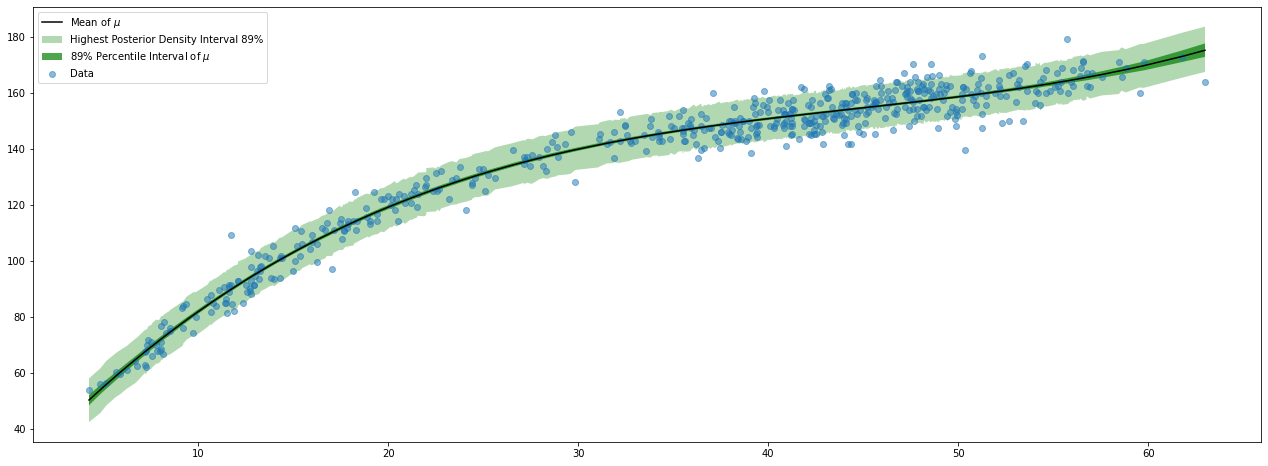

In [31]:
alpha_fit=fit.stan_variable('alpha')
mu_fit=fit.stan_variable('mu')
h_sim=fit.stan_variable('h_sim')
hdi_height = az.hdi(h_sim, 0.89)
hdi_mu = az.hdi(mu_fit, 0.89)

fig, axes = plt.subplots(figsize=(22, 8))

axes.fill_between(d.weight.values, hdi_height[:,0], hdi_height[:,1], facecolor='green', alpha=0.3);
axes.fill_between(d.weight.values, hdi_mu[:,0], hdi_mu[:,1], facecolor='green', alpha=0.7);
axes.scatter(d.weight,d.height,alpha=0.5)
axes.plot(d.weight.values, np.mean(mu_fit,0), color='black')
axes.legend(['Mean of $\mu$', 'Highest Posterior Density Interval 89%', '89% Percentile Interval of $\mu$', 'Data'])
plt.show()